# Clustering: Finding Wine Classes from Chemical Properties
- The goal of this analysis is to use unsupervised machine learning (clustering) to cluster different types of wine according to its chemical and physical properties. 

- The dataset contains labels of the wine classes (ground truth), however this column is removed from the beginning to perform the clustering. 

### Import Necesary Packages

In [1]:
#Import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (silhouette_score,
                             davies_bouldin_score,
                             calinski_harabasz_score,
                             confusion_matrix, 
                             adjusted_rand_score, 
                             normalized_mutual_info_score,
                             homogeneity_completeness_v_measure,
                             silhouette_score
                            )

import plotly.graph_objects as go
import pacmap

import evaluation_metrics

### Load Dataset

- The data set is loaded from a .CSV file.
- The column containing the original labels (wine classes) is removed and stored separately.

In [2]:
# Load the CSV file into a DataFrame
wine_dataset_with_class = pd.read_csv('../data/processed/wine_data.csv')

# Create new dataset without class information
wine_dataset = wine_dataset_with_class.drop('Class', axis=1, inplace=False)

# Separate true labels 
true_cluster_labels = wine_dataset_with_class.iloc[:, 0].to_numpy()
 

## 1. Exploratory Data Analysis (EDA)


### 1.1 Visualize Dataframe and Summary Statistics

- We visualize the first rows of the dataset to verify it loaded properly.

- There are 13 features describing each wine.

In [3]:
#Preview the Dataframe
wine_dataset.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


- Summary statistic values are extracted for each feature to understand better the data. 
- Some features, like Proline and Magnesium have a much higher range of variability, which may become a problem when modeling. It is necessary to standardize the data. 

In [4]:
#Summary Statistics
wine_dataset.describe()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


### 1.2 Visualize Correlations and Distributions 
- A correlation heatmap (Pearson correlation) is generated to visualize the correlation between the different features.
- For example, these are some of the feature pairs with relevant correlation values:
    - Flavanoids & Total Phenols 
    - Alcohol & Proline
    - OD280/OD315 of diluted wines & Total Phenols
    - Malic Acid & Hue
    
- Total Phenols and Flavanoids have very similar correlations across features.


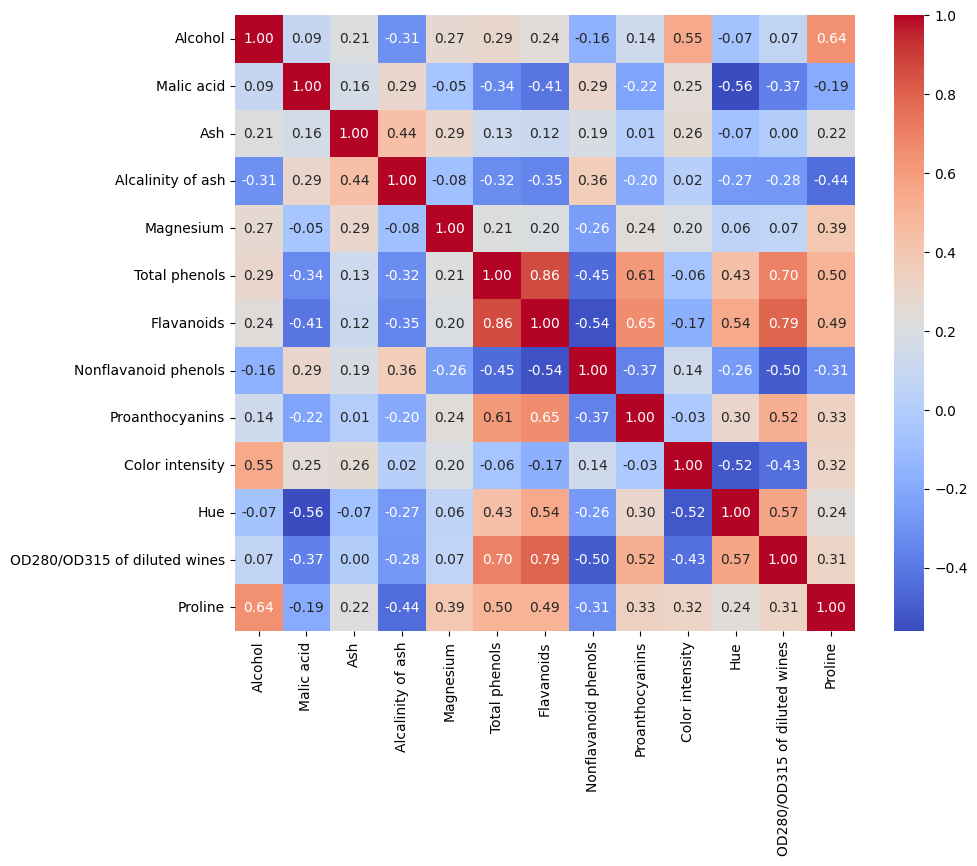

In [5]:
# Simple Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(wine_dataset.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

- Pair plots of all the features help us visualize the distributions for each combination.

- Some feature pairs have a visible linear correlation, as shown earlier in the correlation heatmap.

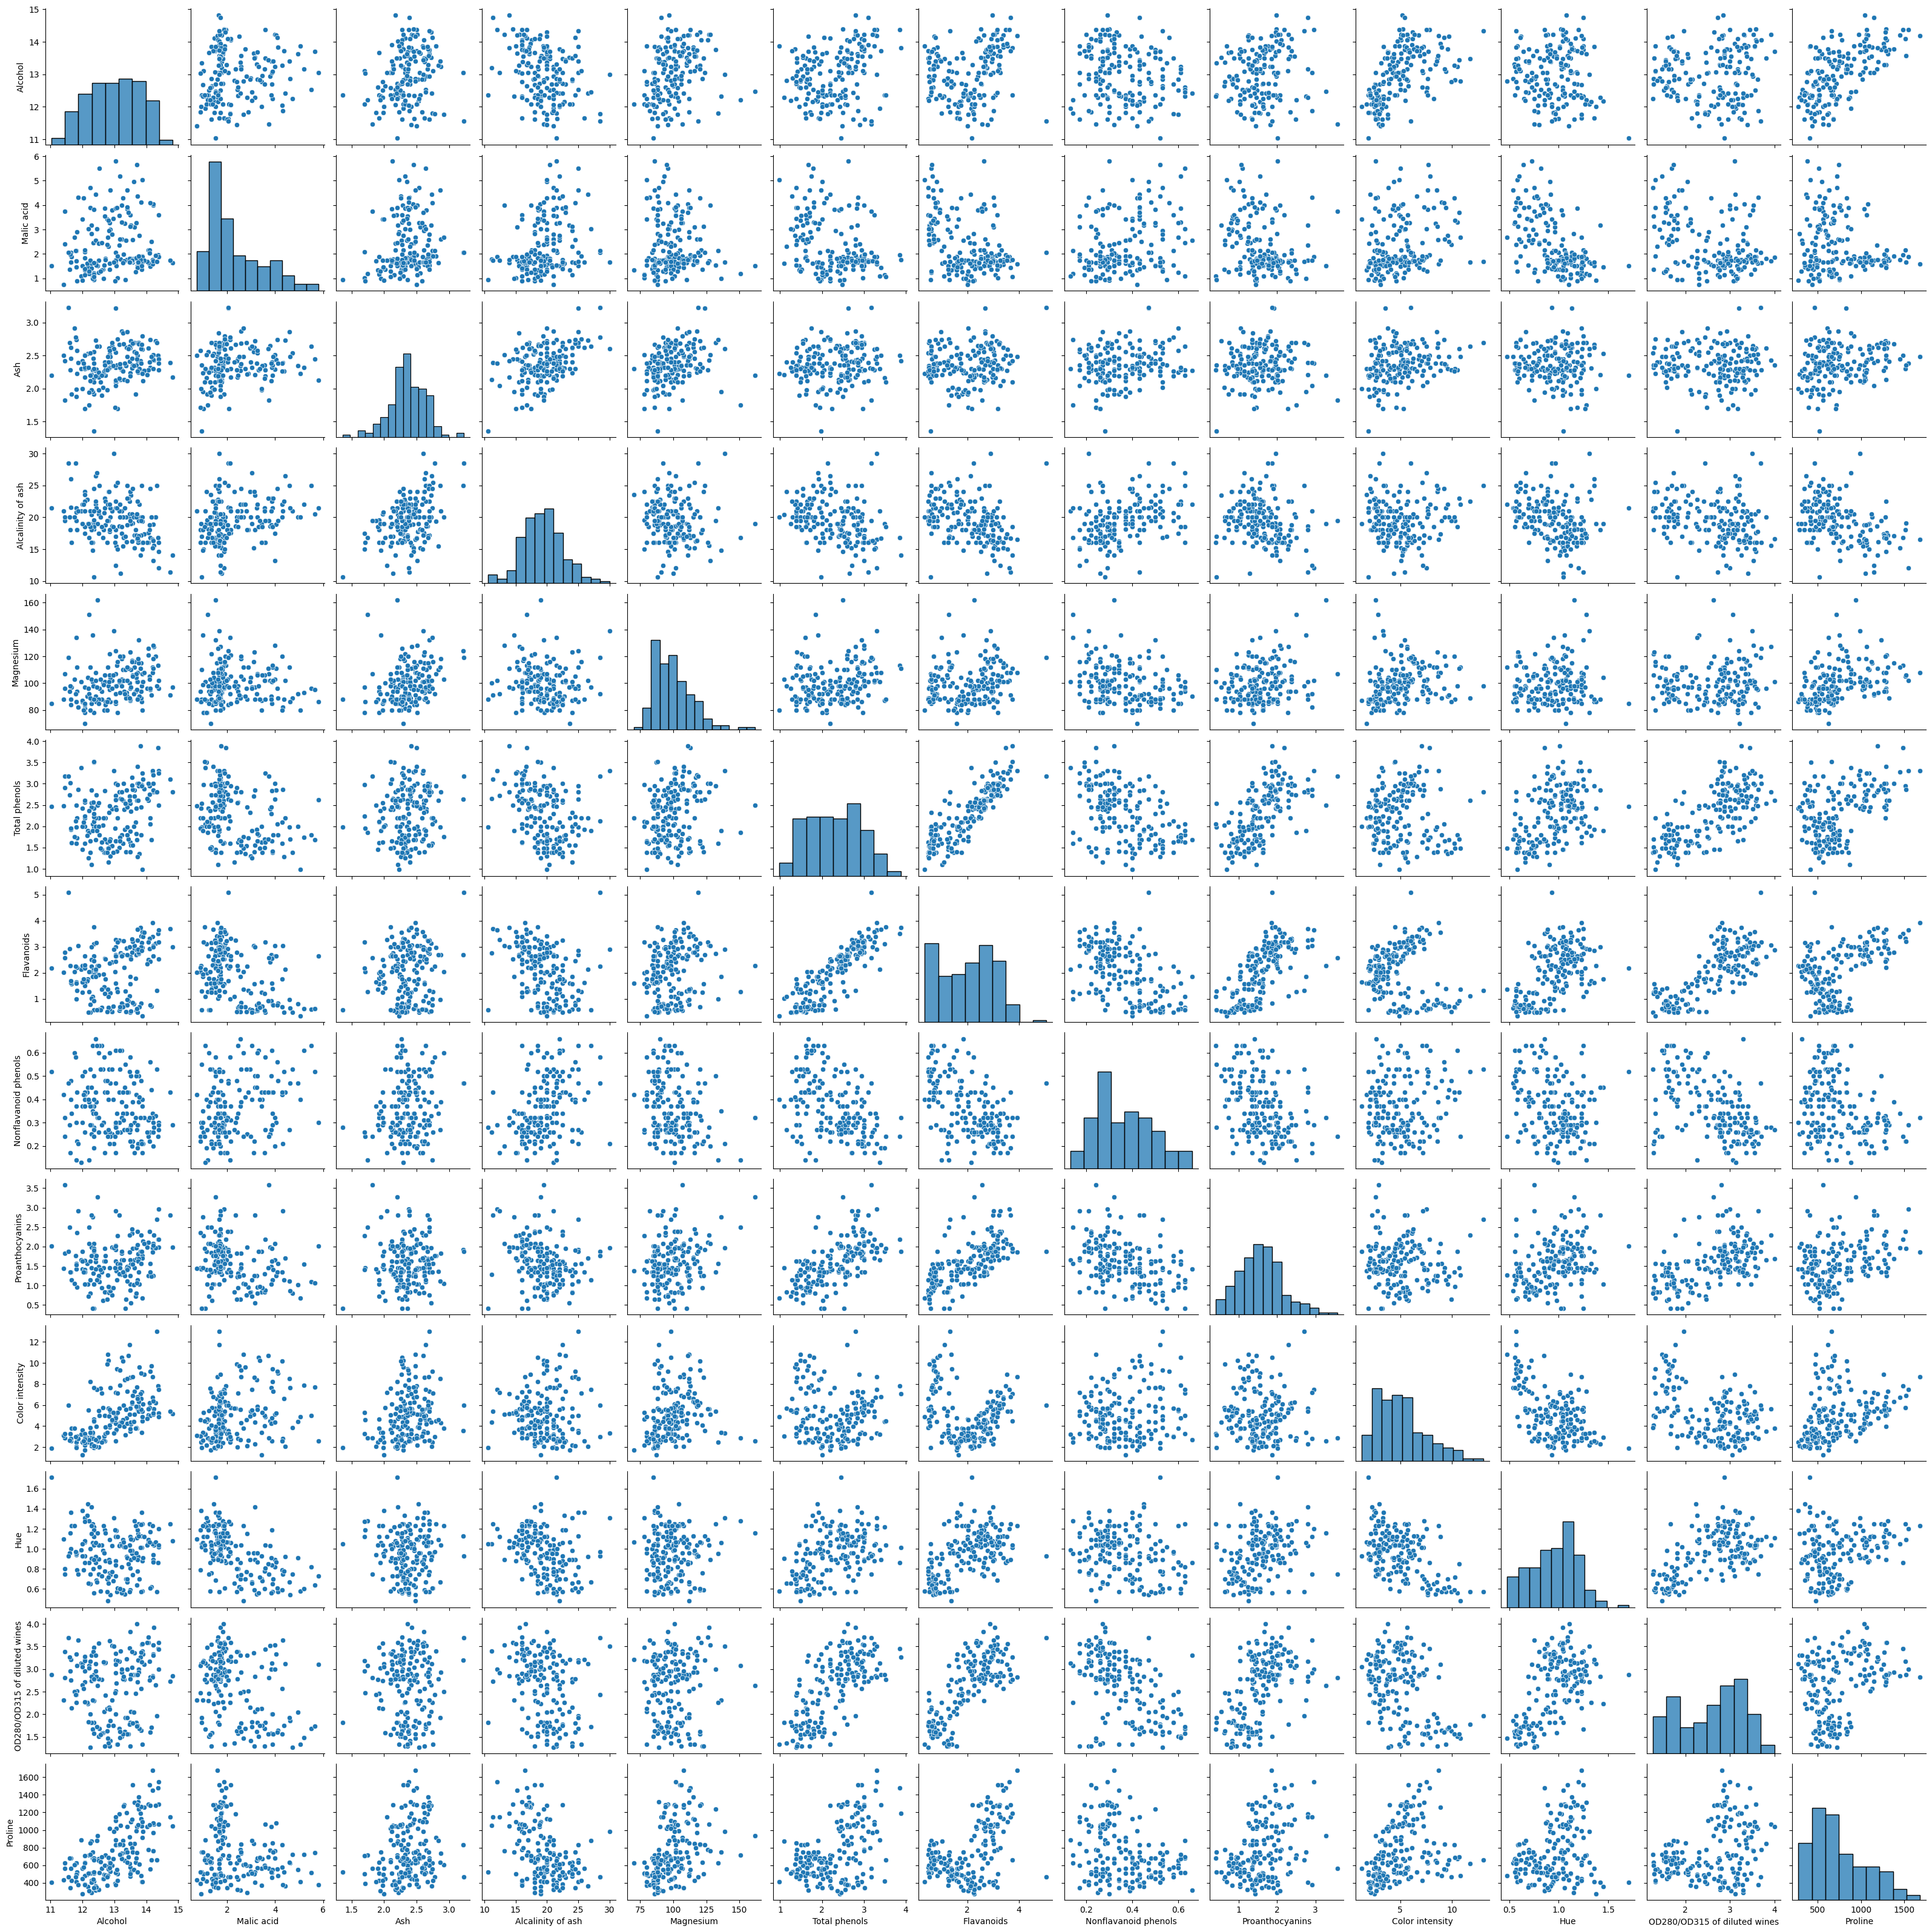

In [6]:
# Pairplot 
sns.pairplot(wine_dataset)

## 2. Clustering

- K-means clustering algorithm is used across the analysis.


### 2.1 Evaluating The Optimum Number of Clusters 
- A set of evaluation scores are computed and plotted for various cluster numbers, for the K-means algorithm, to discover the optimum value:

    - Within-cluster sum of squares (WCSS) or "Elbow Curve": Where the optimum number of clusters is at the inflection point
    - Silhouette Score: We look for the maximum value
    - Calinski Harabasz Score: We look for the maximum value
    - Davies Bouldin Score: We look for the minimum value
- From the evaluation curves, 3 clusters appear to be the optimum number.

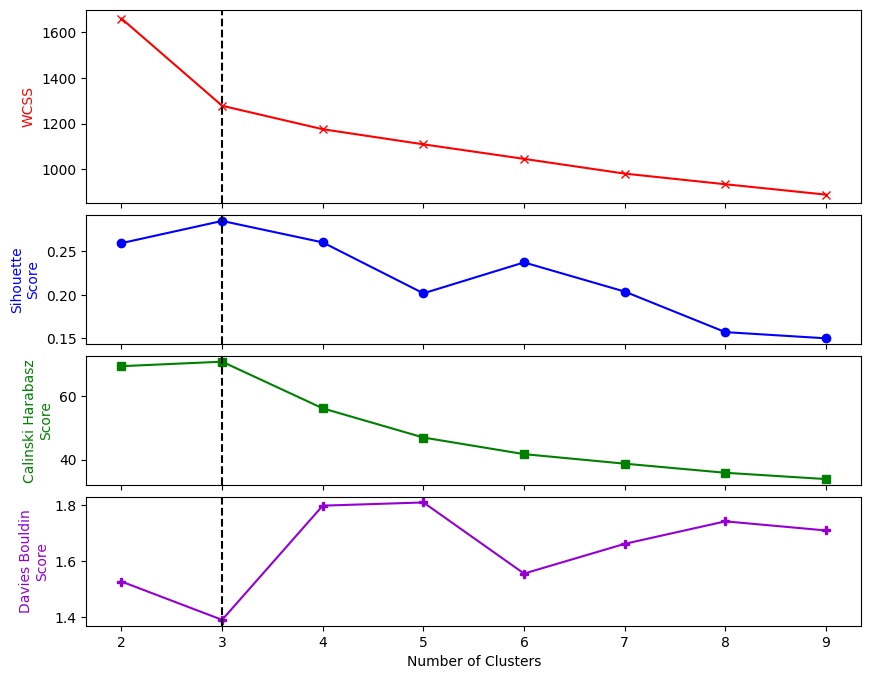

In [7]:

evaluation_metrics.plot_kmeans_evaluation_curves(wine_dataset,cluster_number_evaluation=3, cluster_number=range(2, 10))

### 2.2 K-means Clustering 
- We perform K-means clustering with 3 clusters.
- Sklearn pipelines are used to contain the algorithms.

In [8]:
# Create a K-Means pipeline
kmeans_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale data (standarization)
    ('kmeans', KMeans(n_clusters=3, init='k-means++', max_iter=300, tol=1e-04 ,n_init=10, random_state=42))  # Clustering model
])

In [9]:
# Fit the pipeline
kmeans_pipeline.fit(wine_dataset)
# Extract labels and add 1 to match the original label range
kmeans_labels = kmeans_pipeline['kmeans'].labels_ + 1
kmeans_cluster_centroids = kmeans_pipeline['kmeans'].cluster_centers_

- Box plots are used to visualize the distribution of the data from the clusters that were extracted across all features. 

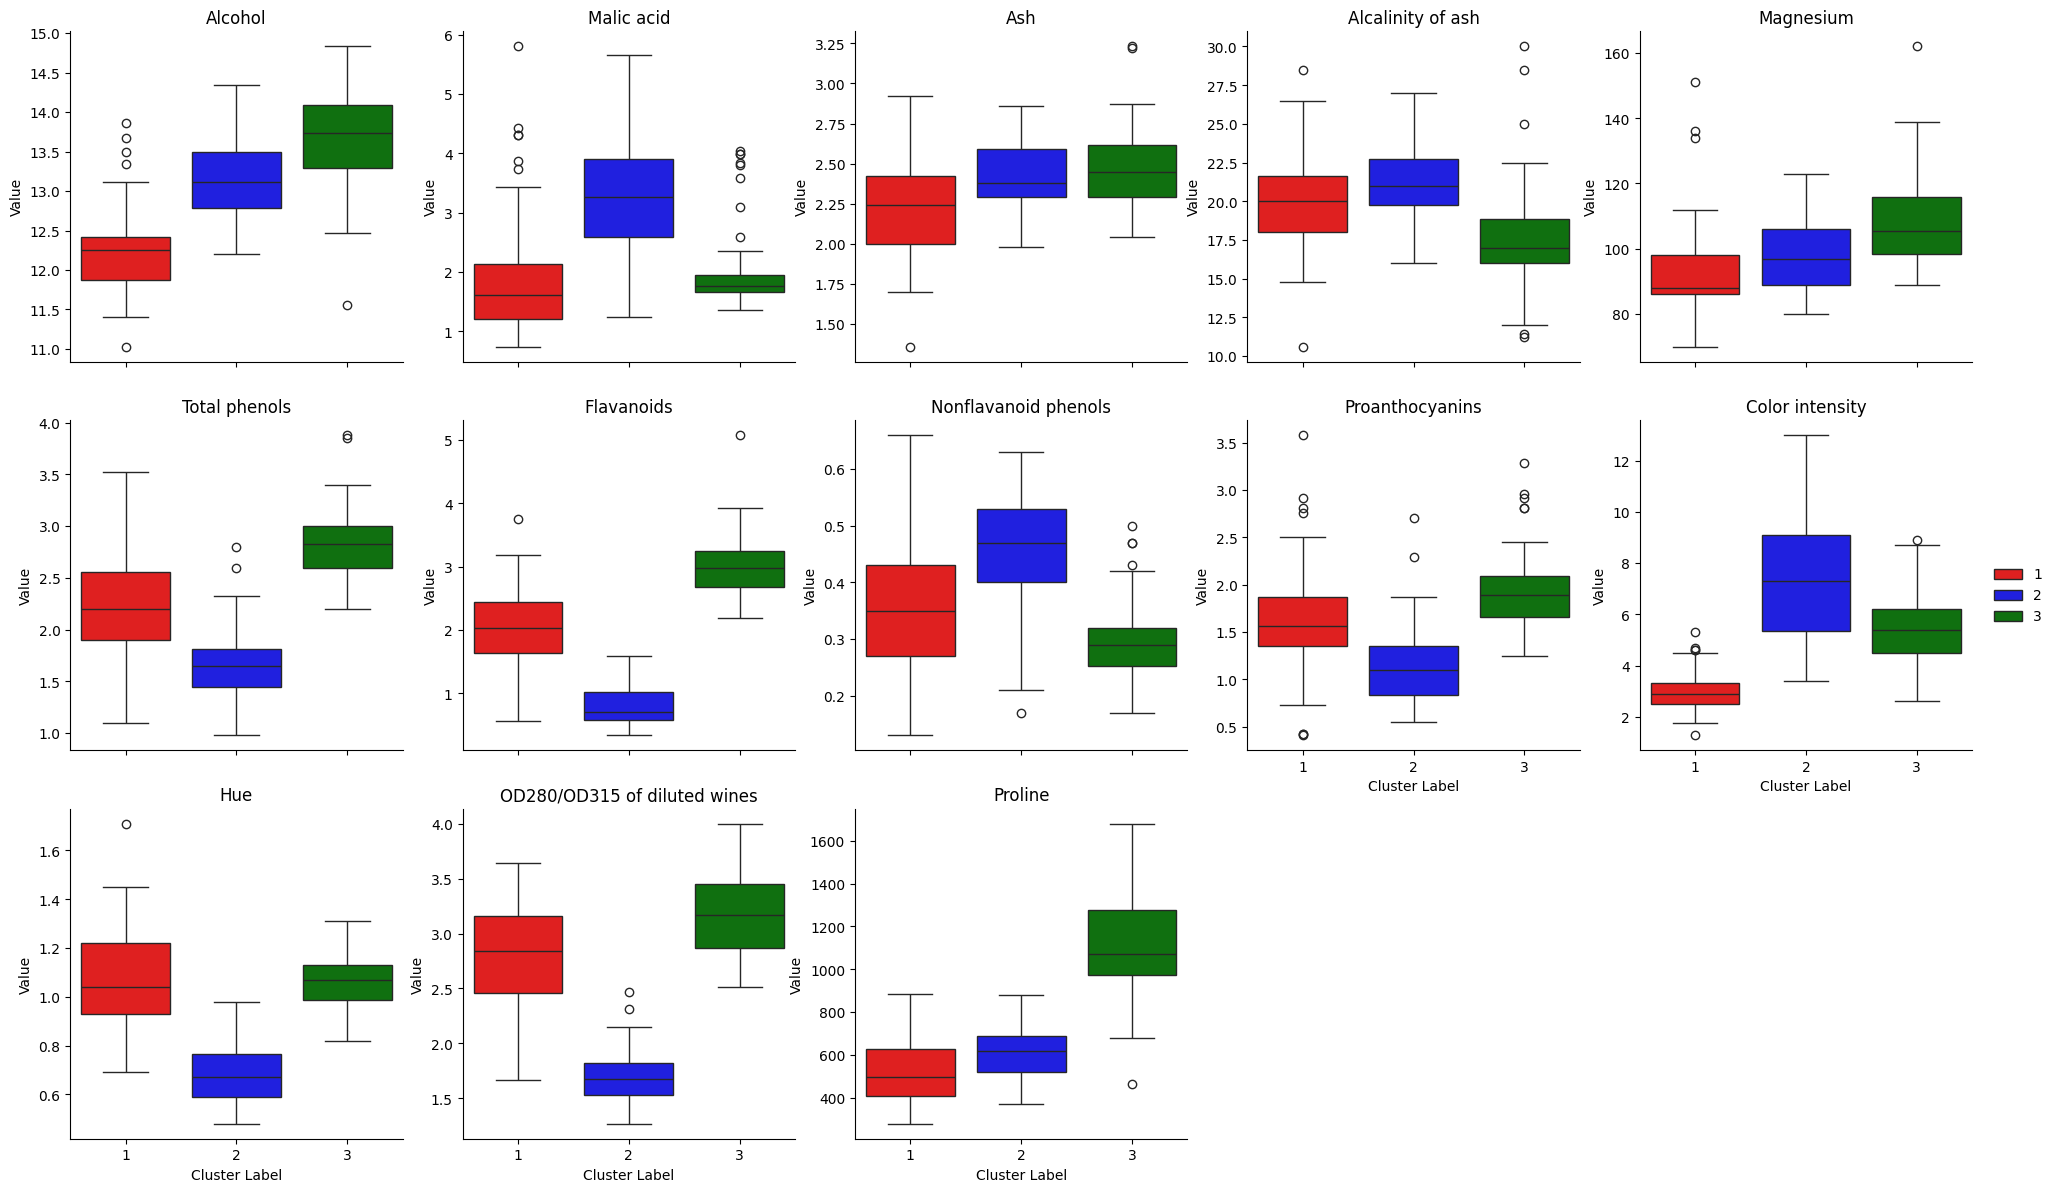

In [10]:

# Combine the original data with cluster labels
wine_dataset_kmeans_labels = pd.concat([pd.DataFrame(wine_dataset), pd.Series(kmeans_labels, name='kmeans_cluster')], axis=1)

# Melt the DataFrame to reshape it for seaborn's boxplot
data_melted = pd.melt(wine_dataset_kmeans_labels, id_vars='kmeans_cluster', var_name='feature', value_name='value')

# Define the color palette specifically for clusters
custom_palette = {1: 'red', 2: 'blue', 3: 'green'}  # Customize your palette here

# Create a FacetGrid, each subplot has a different feature
g = sns.FacetGrid(data_melted, col='feature', col_wrap=5, height=4, sharey=False)
g.map_dataframe(sns.boxplot, x='kmeans_cluster', y='value', hue='kmeans_cluster', palette=custom_palette)
g.add_legend()


# Adjustments to each subplot in the FacetGrid
for ax in g.axes.flatten():
    ax.set_xlabel('Cluster Label')  # Set x-axis label
    ax.set_ylabel('Value') # Set y-axis label
    ax.set_title(ax.get_title().replace('feature = ', ''))

plt.show()


- A radar plot was used to represent how each cluster (wine type) maps the feature space.
- This visualization is based on the standardized mean values of the features for each cluster (wine type).

- The way the different clusters map the features gives a "fingerprint" of each class of wine.

In [11]:
# Get mean values of features for each cluster class.
wine_dataset_kmeans_mean = wine_dataset_kmeans_labels.groupby('kmeans_cluster').mean()

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
temp_wine_dataset_kmeans_mean_standardized = scaler.fit_transform(wine_dataset_kmeans_mean)
# Convert the scaled data back to a DataFrame
wine_dataset_kmeans_mean_standardized = pd.DataFrame(temp_wine_dataset_kmeans_mean_standardized, 
                                                    columns=wine_dataset_kmeans_mean.columns,
                                                    index=wine_dataset_kmeans_mean.index).reset_index()


# Extract categories from DataFrame columns (except the last one, which contains product names)
categories = wine_dataset_kmeans_mean_standardized.columns[1:].tolist()

# Create a figure
fig = go.Figure()



# Color settings for each cluster
colors = ['red', 'blue', 'green']

# Add a trace for each row in the DataFrame, using the color settings
for index, row in wine_dataset_kmeans_mean_standardized.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[categories].values.tolist(),  # Values for each category
        theta=categories,
        fill='toself',
        name=f'Cluster {int(row["kmeans_cluster"])}',  # Use the cluster number as the trace name
        line=dict(color=colors[index % len(colors)])  # Cycle through colors
    ))

# Update layout to refine the chart
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=False,
      range=[-2, 2]  # Adjust the range 
    )),
  showlegend=True,
  
  width=800,  # Set the width of the figure
  height=600  # Set the height of the figure
)

# Show the figure
fig.show()


## 3. Dimensionality Reduction for 2D Visualization

- The aim is to reduce the dimensionality of our dataset from 13 to 2 dimensions, so that the clustering results can be better visualized and inspected. 

### 3.1 PCA 
 
- We reduce the dimensionality of the data to 2 dimensions by principal component analysis (PCA).
- The PCA algorithm is used to project the original 13-D datapoints in a 2-D space.
- Each point plotted in 2-D represents a data point of the original dataset in the new space.
- The colors represent the cluster or class.

- We can visually asses the clustering results.

In [12]:
# Create a PCA pipeline
PCA_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale data (standardization)
    ('pca', PCA(n_components=2,random_state=42)),  # Reduce dimensions
])

# Fit the pipeline to the training data
PCA_projection = PCA_pipeline.fit_transform(wine_dataset) # outputs the projection of the data into 2 dimensions. 

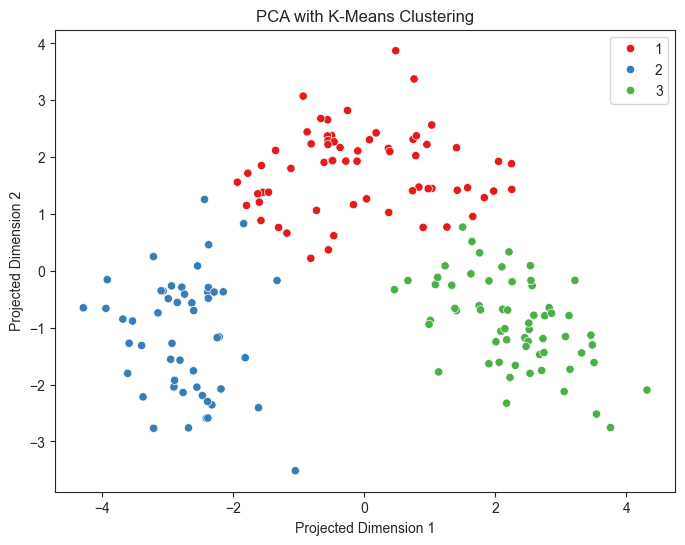

In [13]:
# Set the style of seaborn plots
sns.set_style("ticks")

# Create the scatter plot using seaborn
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.scatterplot(x=PCA_projection[:, 0], y=PCA_projection[:, 1], hue=kmeans_labels, palette='Set1', legend=True)

# Set labels and title
plt.xlabel('Projected Dimension 1')
plt.ylabel('Projected Dimension 2')
plt.title('PCA with K-Means Clustering')

plt.show()

### 3.2 PaCMAP

- The PaCMAP algorithm helps maintain the global and local structure and can help us further visualize  the clustering results.
- It confirms the visualization results obtained by PCA with three separate classes.

- Some points show class-membership errors, which may be due to a difficulty of assignment at cluster borders and is considered normal.

In [ ]:
# Create a PACMAP pipeline
PACPAM_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale data (standarization)
    ('PaCMAP', pacmap.PaCMAP(random_state=42,n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=3, num_iters=500)),  # Reduce dimensions
])

# fit the data (The index of transformed data corresponds to the index of the original data)
wine_dataset_PACMAP_transformed = PACPAM_pipeline.fit_transform(wine_dataset.to_numpy())

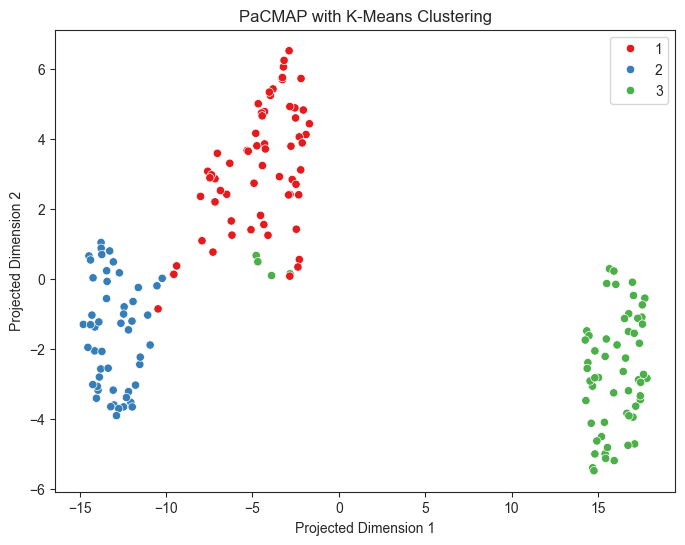

In [15]:
# Set the style of seaborn plots
sns.set_style("ticks")

# Create the scatter plot using seaborn
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.scatterplot(x=wine_dataset_PACMAP_transformed[:, 0], y=wine_dataset_PACMAP_transformed[:, 1], hue=kmeans_labels, palette='Set1', legend=True)

# Set labels and title
plt.xlabel('Projected Dimension 1')
plt.ylabel('Projected Dimension 2')
plt.title('PaCMAP with K-Means Clustering')

plt.show()

## 4. Comparing Clustering Results with Ground Truth Classes

### 4.1 Plotting the Original Clusters on the PCA Projection

- We plot the original classes to visualize and verify if the class encoding "[1,2,3]" is correct and comparable to the results obtained by K-means. 

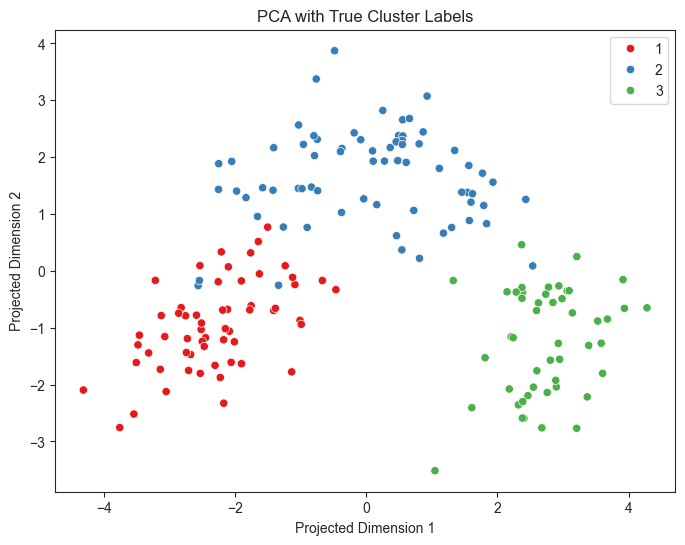

In [16]:
#Visualizing the true cluster labels
# Set the style of seaborn plots
sns.set_style("ticks")

# Create the scatter plot using seaborn
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.scatterplot(x=-PCA_projection[:, 0], y=PCA_projection[:, 1], hue=true_cluster_labels, palette='Set1', legend=True)

# Set labels and title
plt.xlabel('Projected Dimension 1')
plt.ylabel('Projected Dimension 2')
plt.title('PCA with True Cluster Labels')

plt.show()

- It appears that some classes are encoded differently and a re-encoding is necessary. 

In [17]:
#Re-encode the cluster k-means cluster labels

# Define a custom mapping
label_mapping = {
    1: 3,  # Change label 1 to 2
    2: 1,  # Change label 2 to 5
    3: 2   # Change label 3 to 7
}

# Use numpy's vectorize function to apply the mapping
vectorized_map = np.vectorize(label_mapping.get)

# Apply mapping
true_cluster_labels_reencoded = vectorized_map(true_cluster_labels)

### 4.2 Visual Comparison of Original and Extracted Clusters
- We can visually compare the re-encoded original clusters (ground truth) with the clusters found by k-means clustering.

- The results match, except for certain isolated points.

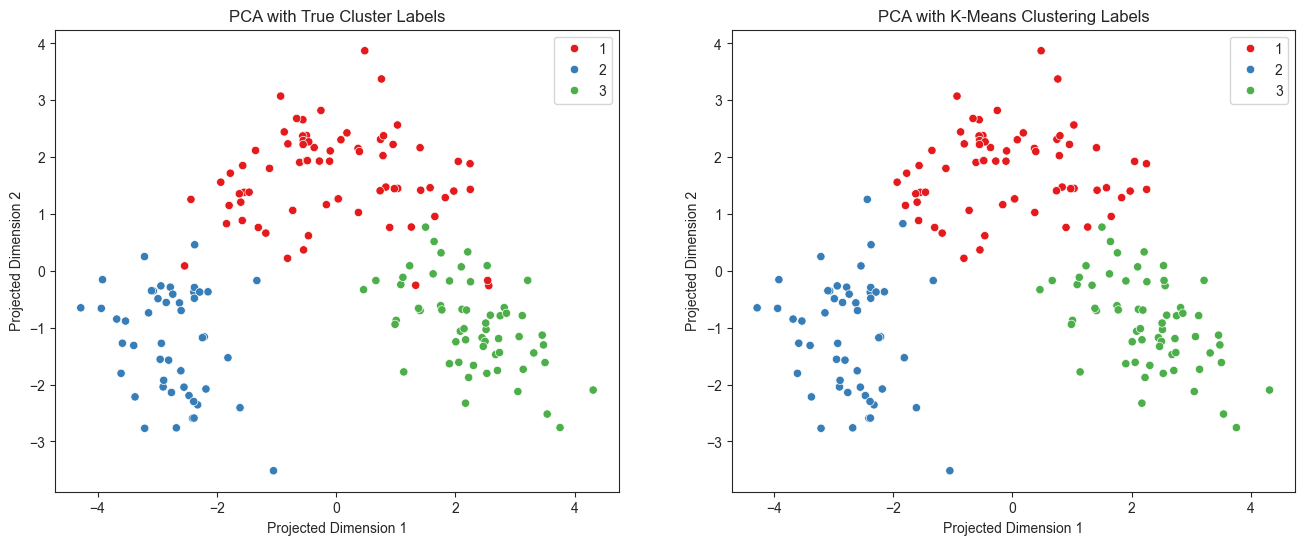

In [18]:
# Set the style of seaborn plots
sns.set_style("ticks")

# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # Total figure size

# Left plot
sns.scatterplot(ax=ax[0], x=PCA_projection[:, 0], y=PCA_projection[:, 1], hue=true_cluster_labels_reencoded, palette='Set1', legend=True)

ax[0].set_xlabel('Projected Dimension 1')
ax[0].set_ylabel('Projected Dimension 2')
ax[0].set_title('PCA with True Cluster Labels')

# Right plot
# Update 'hue' if you have new labels, otherwise it will replicate the left plot
sns.scatterplot(ax=ax[1], x=PCA_projection[:, 0], y=PCA_projection[:, 1], hue=kmeans_labels, palette='Set1', legend=True)

ax[1].set_xlabel('Projected Dimension 1')
ax[1].set_ylabel('Projected Dimension 2')
ax[1].set_title('PCA with K-Means Clustering Labels')

plt.show()


### 4.3 Quantitative Evaluation of Extracted Clusters 

- We compare the original clusters with the ones obtained from k-means clustering.
- A series of scores are calculated for the original and extracted clusters.
- The high score values (with a range from 0 to 1) show a strong match, demonstrating the correctness of our "blind" cluster extraction analysis. 

- Although this is not formally a prediction analysis, the "predicted" or assigned class-membership of the datapoints in the confusion matrix is mainly correct, with a small number of incorrect assignments. 

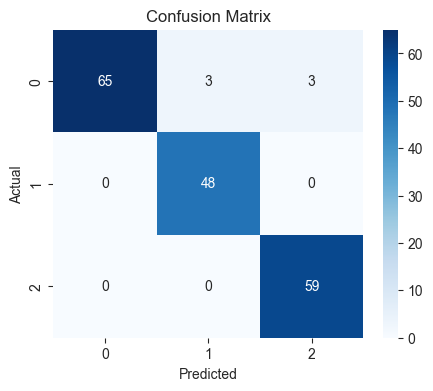

,Metric,Value
0,Adjusted Rand Index,0.897495
1,Normalized Mutual Information,0.875894
2,Homogeneity,0.878843
3,Completeness,0.872964
4,V-Measure,0.875894


In [19]:
# Encode labels
predicted_classes = kmeans_labels

# Confusion matrix
cm = confusion_matrix(true_cluster_labels_reencoded, predicted_classes)

# Adjusted Rand Index
ari = adjusted_rand_score(true_cluster_labels_reencoded, predicted_classes)

# Normalized Mutual Information
nmi = normalized_mutual_info_score(true_cluster_labels_reencoded, predicted_classes)

# Homogeneity, Completeness, and V-Measure
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(true_cluster_labels_reencoded, predicted_classes)

# Display metrics as DataFrame
metrics_df = pd.DataFrame({
    "Metric": ["Adjusted Rand Index", "Normalized Mutual Information", "Homogeneity", "Completeness", "V-Measure"],
    "Value": [ari, nmi, homogeneity, completeness, v_measure]
})

# Display the confusion matrix as a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Display the metrics table
metrics_df


## 5. Conclusions

- 3 wine types (3 clusters) were successfully identified from a dataset containing 13 features of wine (chemical properties).
- K-means algorithm was used for clustering.
- Various scores were used to identify the optimum number of clusters as 3.
- The Results where visually evaluated and confirmed by plotting a 2-D representation of the dataset and its color-coded clusters.

- The "predicted" or extracted K-means clusters where compared with the ground truth class labels, showing a strong match and demonstrating the validity of the method. 

